# FCIQMC (Full Configuration Interaction Quantum Monte Carlo)

論文 [Fermion Monte Carlo without fixed nodes: A game of life, death, and
annihilation in Slater determinant space](https://2024.sci-hub.st/1534/f26924b07d1005f6f9a7be1b525feec7/booth2009.pdf) を読み、Pythonでの実装を試みる。

## 準備

```
$ conda install tqdm pandas
$ conda install -c conda-forge pyscf
```

## 共通の関数を定義

In [22]:
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from pyscf import gto, scf, fci, ao2mo
import random

rng = np.random.default_rng()

def build_hamiltonian(mol):
    E_nuc = mol.energy_nuc()
    # print("E_nuc:", E_nuc)
    elec_num = sum(mol.nelec)
    myhf = mol.HF()
    myhf.kernel()
    mymp2 = myhf.MP2()
    mymp2.kernel() # run mp2
    C = myhf.mo_coeff # molecular coefficient matrix
    h1 = np.matmul((C.T),np.matmul((myhf.get_hcore()),(C)))
    h2 = ao2mo.kernel(mol,C)
    h2 = ao2mo.restore(8,h2,mol.nao_nr())

    H_mat = fci.direct_spin1.pspace(h1, h2, mol.nao_nr(), elec_num, np=70000)[1] # creates Hamiltonian
    H_mat = H_mat + E_nuc * np.eye(H_mat.shape[0])
    nspatorbs = int(mol.nao_nr())

    # --- フル FCI エネルギー ---
    cis = fci.FCI(myhf)
    E_fci, civec = cis.kernel(h1, h2, C.shape[1], mol.nelec)
    E_HF = myhf.e_tot

    return H_mat, E_fci, E_HF

# mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
# H_mat, E_fci, E_HF = build_hamiltonian(mol)
# print(H_mat)


def FCIQMC(mol, shift=0, init_n_walker=1, n_steps=5000, step_starting_shift_upd=500, n_prod=2500,
           shift_upd_interval=10, dt=0.001, damping=0.05, debug=True):
    """
    Full Configuration Interaction Quantum Monte Carlo (FCIQMC) を用いて基底状態エネルギーを推定する。

    Args:
        mol: PySCFのMoleculeオブジェクト
        shift: 初期シフト値 S(0)。ウォーカー数の増減を抑制するためのエネルギー的バイアス
        init_n_walker: 初期状態（参照決定基）に配置するウォーカー数
        n_steps: シミュレーションの総ステップ数
        step_starting_shift_upd: Shift の更新を開始するステップ。初期緩和期間としてこのステップまでは shift を固定する。
        shift_upd_interval: Shift をどの頻度で更新するか（ステップ単位）。例えば 10 なら、10 ステップごとに shift を更新する。
        n_prod: E_projの平均を計算するステップ数（処理完了時からこのステップ数遡って平均を取る）
        dt: imaginary time step（時間刻み）。小さいほど安定するが計算コストが増える
        damping: Shift更新時の更新の程度表すパラメータ
        debug: デバッグモード
        

    Returns:
        tuple:
            - **E_est (float)**: 最終 1000 ステップの projected energy の平均（推定エネルギー）
            - **hist_population (list[int])**: 各ステップのウォーカー総数の履歴
            - **hist_shift (list[float])**: 各ステップの shift の履歴
            - **hist_energy (list[float])**: 各ステップの projected energy の履歴
    """    
    H_mat, E_fci, E_HF = build_hamiltonian(mol)
    # H_mat = np.array([
    #     [-1.13727,  0.0,      0.18129, -0.18129,  0.0,      0.0     ],
    #     [ 0.0,     -0.51055,  0.0,      0.0,      0.0,      0.0     ],
    #     [ 0.18129,  0.0,     -0.67894,  0.0,      0.0,      0.18129 ],
    #     [-0.18129,  0.0,      0.0,     -0.67894,  0.0,     -0.18129 ],
    #     [ 0.0,      0.0,      0.0,      0.0,     -0.51055,  0.0     ],
    #     [ 0.0,      0.0,      0.18129, -0.18129,  0.0,     -0.16889]
    # ])
    # E_HF = H_mat[0, 0]
    print(f"--- FCI Matrix ---")
    print(H_mat.shape)
    print(H_mat)
    

    # print('E_HF:', E_HF)
    H_mat = H_mat - np.eye(H_mat.shape[0]) * E_HF
    print(f"--- K Matrix ---")
    print(H_mat)
    
    E_est = 0
    hist_population, hist_shift, hist_energy = [], [], []
    
    diag_H = np.diag(H_mat)    
    pre_shift = shift
    pre_pop = init_n_walker

    # 基底状態（Hartree-Fock解）のインデックスを特定
    # PySCFのFCIでは通常、最初の行列要素がHF状態に対応します
    ref_det_idx = 0 
        
    # ウォーカーの初期化 {det_index: signed_population}
    # 符号付き整数で管理（+1, -1など）
    walkers = {ref_det_idx: init_n_walker}

    print('\n---- Initial walkers ----')
    for k, v in walkers.items():
        tqdm.write(f"{v} walkers on {k}th determinant")

    
    for step in tqdm(range(n_steps), disable=(not debug)):
        new_walkers = defaultdict(int)
        
        # walkersが乗っている行列式の全てのインデックスを取得
        current_dets = list(walkers.keys())
        # if step % 1000 == 0:
        #     tqdm.write(f"current_dets: {current_dets}")

        
        for i in current_dets:
            n_i = walkers[i] # ith行列式上のウォーカー数（符号付き）
            if n_i == 0: continue

            # ----- Spawning Step -----
            row = H_mat[i]
            # 非ゼロ要素のインデックスを取得
            connected_dets = np.where(row != 0)[0]
            # 対角要素は自分自身への遷移を表すので処理しない
            connected_dets = connected_dets[connected_dets != i]
            # ランダムに遷移先determinant jを候補に選ぶ
            j = np.random.choice(connected_dets)
            h_ij = row[j]

            # Spawning probability: Ps = dt * |H_ij|
            # 生成される数: sign(walker) * sign(-H_ij)
            p_gen = 1/len(connected_dets)
            prob_spawn = dt * abs(h_ij) / p_gen

            # 全てのwalkerに対して、spawnを試みる
            n_spawn = np.full(abs(n_i), 0)
            prob_spawn_frac, prob_spawn_int = math.modf(prob_spawn)
            if prob_spawn_int > 1:
                n_spawn = np.full(abs(n_i), prob_spawn_int)
            n_spawn += (np.random.rand(abs(n_i)) <= prob_spawn).astype(int)
            
            # h_ij>0ならば親と異符号、h_ij<0ならば親と同符号のwalkerを遷移先jth行列式の上に生成
            if h_ij > 0:
                new_walkers[j] += -np.sign(n_i) * np.sum(n_spawn)
            else:
                new_walkers[j] += np.sign(n_i) * np.sum(n_spawn)


            # ----- Diagonal Step (Death/Cloning) -----
            # Pd = exp(-dt * (H_ii - S)) - 1  ~ -dt * (H_ii - S)
            h_ii = diag_H[i]
            prob_death = dt * (h_ii - shift)
            n_walker_on_D = n_i
            sign = np.sign(n_walker_on_D)

            # prob_deathの確率でdeath/cloneする（対象となるwalkerの数をカウントする）
            count = np.sum(np.random.rand(abs(n_i)) <= abs(prob_death))
            if prob_death > 0:
                # prob_deathが正ならwalkerをcount分消滅させる
                n_walker_on_D = sign * (abs(n_walker_on_D) - count)
            else:
                # prob_deathが負ならwalkerをcount分複製する
                n_walker_on_D = sign * (abs(n_walker_on_D) + count)    
            walkers[i] = n_walker_on_D
            

        # ----- Annihilation Step -----
        for idx, n in new_walkers.items():
            walkers[idx] = walkers.get(idx, 0) + n

        # ---- Shift Update -----
        current_pop = sum(abs(w) for w in walkers.values())
        if step > step_starting_shift_upd: # 初期緩和後
            if step % shift_upd_interval == 0:
                shift = pre_shift - (damping / (shift_upd_interval*dt)) * np.log(current_pop / pre_pop)
                pre_shift = shift
        hist_shift.append(shift)
        pre_pop = current_pop
        hist_population.append(current_pop)
        
        # ----- Energy Estimation (Projected Energy) -----
        # E_HF2 = diag_H[ref_det_idx]  # これはE_HFではない
        row0 = H_mat[ref_det_idx]
        num_ref = walkers.get(ref_det_idx, 0)

        # 論文では、singles/doublesに限定して合計している
        # この実装だとそもそもFCI行列の成分がsingles/doubles以外が0になっているので、
        # 全部を合計していて、結局singles/doublesだけが合計されることになっている
        E_proj = E_HF + sum(row0[idx]*v/num_ref for idx, v in walkers.items() if idx != ref_det_idx)
        
        # 生成したコードでは論文にはない項を足していた
        # これはハミルトニアンに各反発エネルギーが含まれているかいないかの解釈が論文と異なっているため？
        # これを含めなければ近い値に収束するので、コメントアウトしておく
        # E_proj += mol.energy_nuc()
        hist_energy.append(E_proj)
        
        if step % 1000 == 0 and debug:
            tqdm.write(f"Step {step}: Walkers={current_pop}, Shift={shift:.5f}, E_proj={E_proj:.6f}")
            for k, v in walkers.items():
                if v != 0:
                    tqdm.write(f"  {v} walkers on {k}th determinant")
    
    # n_prod件のhist_energyデータを10分割して平均を取り、標準偏差を求める
    n_block = 10
    hist_energy_prod = np.array(hist_energy[-n_prod:])
    block_size = len(hist_energy_prod) // n_block
    hist_energy_prod = hist_energy_prod[:n_block * block_size]  # 小数分を切り捨てる
    blocks = hist_energy_prod.reshape(n_block, block_size)
    block_means = blocks.mean(axis=1)
    E_sd = np.std(block_means, ddof=1)
    E_est = np.mean(block_means)
    
    # E_est = np.mean(hist_energy_prod) # 最後のn_prodステップの平均
    avg_shift = np.mean(hist_shift[-n_prod:]) # 最後のn_prodステップの平均

    
    print('\n---- Walkers (result) ----')
    for k, v in walkers.items():
        if v != 0:
            print(f"{v} walkers on {k}th determinant")

    return E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy


def plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy):
    plt.figure(figsize=(10, 6))
    plt.plot(hist_population)
    plt.xlabel('Step')
    plt.ylabel('Population')
    plt.yscale('log')
    plt.grid(True)  

    E_corr = np.full_like(hist_shift, E_fci - E_HF)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_shift, label="Shift")
    plt.plot(E_corr, linestyle="--", label=r"${E_{corr}}$")
    plt.xlabel('Step')
    plt.ylabel('Shift')
    plt.legend()
    plt.grid(True)  

    E_fci_arr = np.full_like(hist_energy, E_fci)
    plt.figure(figsize=(10, 6))
    plt.plot(hist_energy, label=r"${E_{proj}}$")
    plt.plot(E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
    plt.xlabel('Step')
    plt.ylabel('Projected Energy')
    plt.legend()
    plt.grid(True)  
    
    plt.show()

## ${H_2}$ 分子 STO-3G

FCIによる基底エネルギーは -1.1373 で、FCIQMCによる推定基底エネルギーは近い値が出る

--- FCI Matrix ---
(4, 4)
[[-1.11675931e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16 -3.49562895e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01 -3.49562895e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  4.62618146e-01]]
--- K Matrix ---
[[ 0.00000000e+00 -3.63850793e-16 -3.63850793e-16  1.81210462e-01]
 [-3.63850793e-16  7.67196412e-01  1.81210462e-01  1.90003444e-16]
 [-3.63850793e-16  1.81210462e-01  7.67196412e-01  1.90003444e-16]
 [ 1.81210462e-01  1.90003444e-16  1.90003444e-16  1.57937745e+00]]

---- Initial walkers ----
1 walkers on 0th determinant


 10%|████████▌                                                                                 | 2850/30000 [00:00<00:00, 28493.71it/s]

Step 0: Walkers=1, Shift=0.70000, E_proj=-1.116759
  1 walkers on 0th determinant
Step 1000: Walkers=4, Shift=0.70000, E_proj=-1.177163
  3 walkers on 0th determinant
  -1 walkers on 3th determinant
Step 2000: Walkers=7, Shift=0.70000, E_proj=-1.146961
  6 walkers on 0th determinant
  -1 walkers on 3th determinant
Step 3000: Walkers=17, Shift=0.70000, E_proj=-1.140921
  15 walkers on 0th determinant
  -2 walkers on 3th determinant
Step 4000: Walkers=36, Shift=0.70000, E_proj=-1.139411
  32 walkers on 0th determinant
  -4 walkers on 3th determinant
Step 5000: Walkers=85, Shift=0.70000, E_proj=-1.149478
  72 walkers on 0th determinant
  -13 walkers on 3th determinant


 28%|█████████████████████████▏                                                                | 8395/30000 [00:00<00:00, 24229.07it/s]

Step 6000: Walkers=143, Shift=0.70000, E_proj=-1.131860
  132 walkers on 0th determinant
  -11 walkers on 3th determinant
Step 7000: Walkers=306, Shift=0.70000, E_proj=-1.139411
  272 walkers on 0th determinant
  -34 walkers on 3th determinant
Step 8000: Walkers=581, Shift=0.70000, E_proj=-1.132709
  534 walkers on 0th determinant
  -47 walkers on 3th determinant
Step 9000: Walkers=1230, Shift=0.70000, E_proj=-1.135091
  1117 walkers on 0th determinant
  -113 walkers on 3th determinant
Step 10000: Walkers=2488, Shift=0.70000, E_proj=-1.137997
  2227 walkers on 0th determinant
  -261 walkers on 3th determinant


 44%|██████████████████████████████████████▋                                                  | 13053/30000 [00:00<00:01, 16574.26it/s]

Step 11000: Walkers=4323, Shift=0.40308, E_proj=-1.136620
  3896 walkers on 0th determinant
  -427 walkers on 3th determinant
Step 12000: Walkers=6052, Shift=0.25124, E_proj=-1.136113
  5468 walkers on 0th determinant
  -584 walkers on 3th determinant
Step 13000: Walkers=7375, Shift=0.11016, E_proj=-1.137030
  6633 walkers on 0th determinant
  -742 walkers on 3th determinant


 50%|████████████████████████████████████████████                                             | 14863/30000 [00:00<00:01, 13641.58it/s]

Step 14000: Walkers=8150, Shift=0.06499, E_proj=-1.136620
  7345 walkers on 0th determinant
  -805 walkers on 3th determinant
Step 15000: Walkers=8712, Shift=0.03318, E_proj=-1.137740
  7808 walkers on 0th determinant
  -904 walkers on 3th determinant


 55%|████████████████████████████████████████████████▌                                        | 16373/30000 [00:01<00:01, 11534.86it/s]

Step 16000: Walkers=9163, Shift=0.02446, E_proj=-1.136643
  8257 walkers on 0th determinant
  -906 walkers on 3th determinant
Step 17000: Walkers=9507, Shift=0.00689, E_proj=-1.137278
  8540 walkers on 0th determinant
  -967 walkers on 3th determinant


 63%|████████████████████████████████████████████████████████▎                                 | 18770/30000 [00:01<00:01, 9753.10it/s]

Step 18000: Walkers=9716, Shift=0.00745, E_proj=-1.135895
  8788 walkers on 0th determinant
  -928 walkers on 3th determinant
Step 19000: Walkers=9928, Shift=0.01454, E_proj=-1.134604
  9038 walkers on 0th determinant
  -890 walkers on 3th determinant


 69%|██████████████████████████████████████████████████████████████▏                           | 20720/30000 [00:01<00:01, 8645.93it/s]

Step 20000: Walkers=10226, Shift=-0.00908, E_proj=-1.135815
  9253 walkers on 0th determinant
  -973 walkers on 3th determinant
Step 21000: Walkers=10378, Shift=-0.00524, E_proj=-1.136704
  9349 walkers on 0th determinant
  -1029 walkers on 3th determinant


 77%|█████████████████████████████████████████████████████████████████████▋                    | 23214/30000 [00:01<00:00, 7697.94it/s]

Step 22000: Walkers=10457, Shift=-0.00237, E_proj=-1.136431
  9433 walkers on 0th determinant
  -1024 walkers on 3th determinant
Step 23000: Walkers=10599, Shift=-0.00758, E_proj=-1.136580
  9554 walkers on 0th determinant
  -1045 walkers on 3th determinant


 85%|████████████████████████████████████████████████████████████████████████████▍             | 25494/30000 [00:02<00:00, 7579.29it/s]

Step 24000: Walkers=10695, Shift=-0.02994, E_proj=-1.137072
  9617 walkers on 0th determinant
  -1078 walkers on 3th determinant
Step 25000: Walkers=10632, Shift=-0.05669, E_proj=-1.139296
  9456 walkers on 0th determinant
  -1176 walkers on 3th determinant


 90%|█████████████████████████████████████████████████████████████████████████████████         | 27007/30000 [00:02<00:00, 7495.50it/s]

Step 26000: Walkers=10259, Shift=-0.04297, E_proj=-1.136635
  9245 walkers on 0th determinant
  -1014 walkers on 3th determinant
Step 27000: Walkers=10021, Shift=-0.04243, E_proj=-1.136802
  9023 walkers on 0th determinant
  -998 walkers on 3th determinant


 98%|███████████████████████████████████████████████████████████████████████████████████████▉  | 29317/30000 [00:02<00:00, 7588.13it/s]

Step 28000: Walkers=9874, Shift=-0.02833, E_proj=-1.136704
  8895 walkers on 0th determinant
  -979 walkers on 3th determinant
Step 29000: Walkers=9835, Shift=-0.03847, E_proj=-1.138441
  8784 walkers on 0th determinant
  -1051 walkers on 3th determinant


100%|█████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:02<00:00, 10466.18it/s]



---- Walkers (result) ----
8722 walkers on 0th determinant
-984 walkers on 3th determinant
E_fci=-1.137283834488502, E_HF=-1.1167593073964248
------------------------------
FCI Energy: -1.137284 Ha
Final FCIQMC Energy: -1.137114 ±  0.000496 Ha
Average shift: -0.026350 Ha => Energy: -1.143109610029283


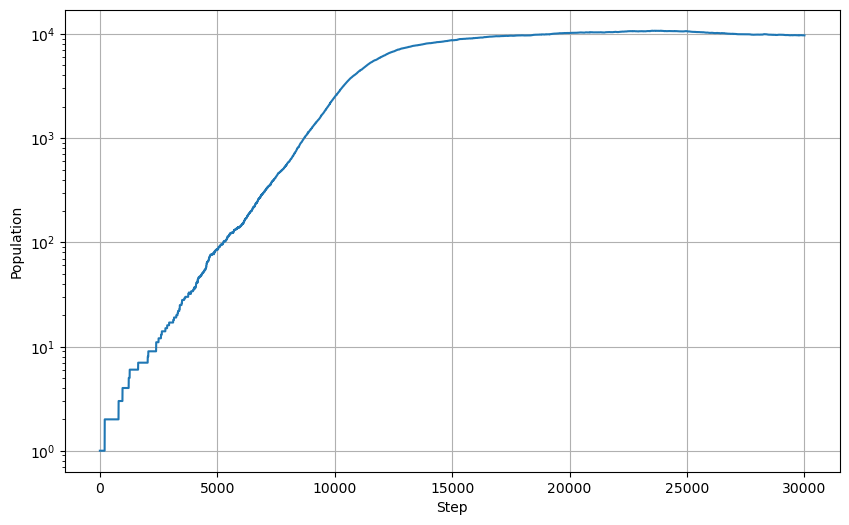

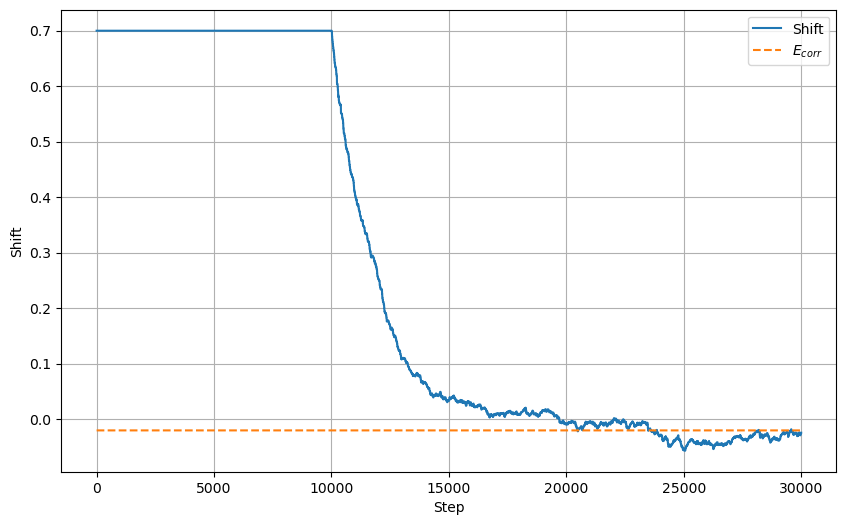

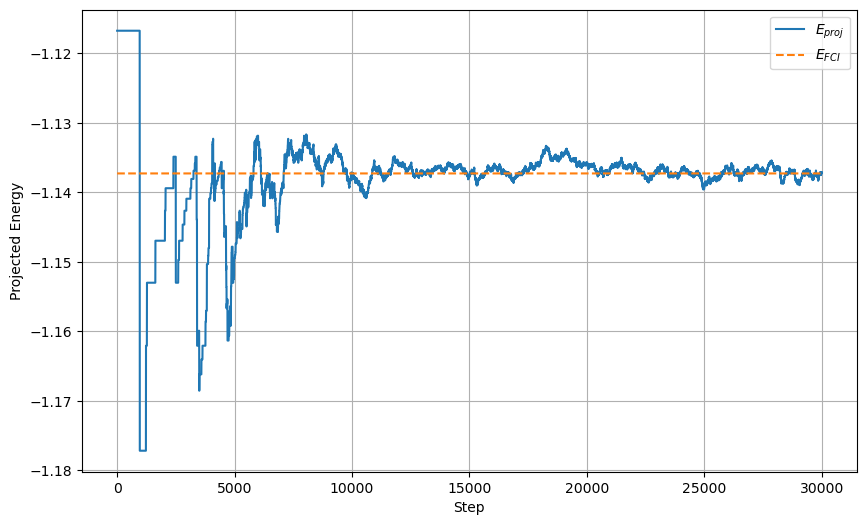

In [8]:
from pyscf import gto

# H2分子の定義 (0.74 Angstrom)
mol = gto.M(atom='H 0 0 0; H 0 0 0.74', basis='sto-3g', verbose=0)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=30000, n_prod=10000, step_starting_shift_upd=10000)

print(f"E_fci={E_fci}, E_HF={E_HF}")

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${H_3^+}$ (sto-3g)
FCI行列は9x9

converged SCF energy = -1.24591513197544
E(RMP2) = -1.26559786762945  E_corr = -0.0196827356540126
E(SCS-RMP2) = -1.26953441476026  E_corr = -0.0236192827848151
--- FCI Matrix ---
(9, 9)
[[-1.24591513e+00  2.78282448e-17 -9.82897130e-09  2.78282448e-17
   1.44076448e-01 -4.65022949e-17 -9.82897130e-09 -4.65022949e-17
   1.44076569e-01]
 [ 2.78282448e-17 -6.16148605e-01 -4.94150488e-17  1.44076448e-01
   2.23904423e-12 -9.56437226e-02 -4.65022949e-17 -9.56440818e-02
  -2.23896578e-12]
 [-9.82897130e-09 -4.94150488e-17 -6.16130888e-01 -4.65022949e-17
  -9.56437226e-02 -2.23892764e-12  1.44076569e-01 -2.23896578e-12
   9.56396165e-02]
 [ 2.78282448e-17  1.44076448e-01 -4.65022949e-17 -6.16148605e-01
   2.23904423e-12 -9.56440818e-02 -4.94150488e-17 -9.56437226e-02
  -2.23896578e-12]
 [ 1.44076448e-01  2.23904423e-12 -9.56437226e-02  2.23904423e-12
   1.13702477e-01 -3.38168990e-16 -9.56437226e-02 -3.38168990e-16
   7.58871399e-02]
 [-4.65022949e-17 -9.56437226e-02 -2.23892764e-12 -9.56440

 14%|████████████▍                                                                             | 2763/20000 [00:00<00:00, 27617.38it/s]

Step 0: Walkers=1, Shift=0.80000, E_proj=-1.245915
  1 walkers on 0th determinant
Step 1000: Walkers=3, Shift=0.80000, E_proj=-1.245915
  3 walkers on 0th determinant
Step 2000: Walkers=5, Shift=0.80000, E_proj=-1.245915
  5 walkers on 0th determinant
Step 3000: Walkers=31, Shift=0.80000, E_proj=-1.310750
  20 walkers on 0th determinant
  -1 walkers on 2th determinant
  -6 walkers on 4th determinant
  -1 walkers on 6th determinant
  -3 walkers on 8th determinant


 28%|████████████████████████▊                                                                 | 5525/20000 [00:00<00:01, 13919.89it/s]

Step 4000: Walkers=55, Shift=0.80000, E_proj=-1.285536
  40 walkers on 0th determinant
  -8 walkers on 4th determinant
  -4 walkers on 6th determinant
  -3 walkers on 8th determinant
Step 5000: Walkers=118, Shift=0.80000, E_proj=-1.287798
  86 walkers on 0th determinant
  1 walkers on 2th determinant
  -15 walkers on 4th determinant
  -6 walkers on 6th determinant
  -10 walkers on 8th determinant
Step 6000: Walkers=242, Shift=0.80000, E_proj=-1.276843
  191 walkers on 0th determinant
  -2 walkers on 2th determinant
  -25 walkers on 4th determinant
  -8 walkers on 6th determinant
  -16 walkers on 8th determinant


 43%|██████████████████████████████████████▊                                                   | 8628/20000 [00:00<00:01, 11232.45it/s]

Step 7000: Walkers=507, Shift=0.80000, E_proj=-1.266403
  436 walkers on 0th determinant
  -2 walkers on 2th determinant
  -32 walkers on 4th determinant
  -7 walkers on 6th determinant
  -30 walkers on 8th determinant
Step 8000: Walkers=1173, Shift=0.80000, E_proj=-1.272471
  982 walkers on 0th determinant
  -1 walkers on 2th determinant
  -99 walkers on 4th determinant
  -9 walkers on 6th determinant
  -82 walkers on 8th determinant


 49%|████████████████████████████████████████████▎                                             | 9853/20000 [00:00<00:01, 10073.46it/s]

Step 9000: Walkers=2686, Shift=0.80000, E_proj=-1.272383
  2259 walkers on 0th determinant
  -3 walkers on 2th determinant
  -181 walkers on 4th determinant
  -9 walkers on 6th determinant
  -234 walkers on 8th determinant
Step 10000: Walkers=6175, Shift=0.80000, E_proj=-1.274244
  5152 walkers on 0th determinant
  2 walkers on 2th determinant
  -459 walkers on 4th determinant
  8 walkers on 6th determinant
  -554 walkers on 8th determinant


 59%|█████████████████████████████████████████████████████▏                                    | 11817/20000 [00:01<00:01, 6958.62it/s]

Step 11000: Walkers=12054, Shift=0.49802, E_proj=-1.274486
  10030 walkers on 0th determinant
  15 walkers on 2th determinant
  -917 walkers on 4th determinant
  20 walkers on 6th determinant
  -1072 walkers on 8th determinant


 63%|████████████████████████████████████████████████████████▌                                 | 12564/20000 [00:01<00:01, 5772.48it/s]

Step 12000: Walkers=18239, Shift=0.27219, E_proj=-1.274795
  15186 walkers on 0th determinant
  4 walkers on 2th determinant
  -1645 walkers on 4th determinant
  -5 walkers on 6th determinant
  -1399 walkers on 8th determinant


 66%|███████████████████████████████████████████████████████████▎                              | 13186/20000 [00:01<00:01, 4955.59it/s]

Step 13000: Walkers=22909, Shift=0.14186, E_proj=-1.273392
  19197 walkers on 0th determinant
  47 walkers on 2th determinant
  -1958 walkers on 4th determinant
  -4 walkers on 6th determinant
  -1703 walkers on 8th determinant


 71%|███████████████████████████████████████████████████████████████▊                          | 14169/20000 [00:02<00:01, 3878.91it/s]

Step 14000: Walkers=26592, Shift=0.08691, E_proj=-1.275099
  22038 walkers on 0th determinant
  43 walkers on 2th determinant
  -2114 walkers on 4th determinant
  47 walkers on 6th determinant
  -2350 walkers on 8th determinant


 76%|████████████████████████████████████████████████████████████████████▋                     | 15269/20000 [00:02<00:01, 3141.78it/s]

Step 15000: Walkers=29253, Shift=0.01651, E_proj=-1.276032
  24149 walkers on 0th determinant
  -11 walkers on 2th determinant
  -2618 walkers on 4th determinant
  45 walkers on 6th determinant
  -2430 walkers on 8th determinant


 82%|█████████████████████████████████████████████████████████████████████████▉                | 16432/20000 [00:02<00:01, 2752.30it/s]

Step 16000: Walkers=30119, Shift=-0.00320, E_proj=-1.275456
  24913 walkers on 0th determinant
  -38 walkers on 2th determinant
  -2778 walkers on 4th determinant
  60 walkers on 6th determinant
  -2330 walkers on 8th determinant


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 17500/20000 [00:03<00:00, 2634.89it/s]

Step 17000: Walkers=30185, Shift=-0.01282, E_proj=-1.272969
  25360 walkers on 0th determinant
  -51 walkers on 2th determinant
  -2484 walkers on 4th determinant
  12 walkers on 6th determinant
  -2278 walkers on 8th determinant


 92%|██████████████████████████████████████████████████████████████████████████████████▎       | 18305/20000 [00:03<00:00, 2531.17it/s]

Step 18000: Walkers=30865, Shift=-0.04630, E_proj=-1.275309
  25552 walkers on 0th determinant
  -64 walkers on 2th determinant
  -2456 walkers on 4th determinant
  36 walkers on 6th determinant
  -2757 walkers on 8th determinant


 97%|███████████████████████████████████████████████████████████████████████████████████████   | 19343/20000 [00:04<00:00, 2567.80it/s]

Step 19000: Walkers=30621, Shift=-0.00677, E_proj=-1.273760
  25628 walkers on 0th determinant
  15 walkers on 2th determinant
  -2623 walkers on 4th determinant
  -25 walkers on 6th determinant
  -2330 walkers on 8th determinant


100%|██████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4701.77it/s]



---- Walkers (result) ----
25721 walkers on 0th determinant
6 walkers on 2th determinant
-2559 walkers on 4th determinant
-17 walkers on 6th determinant
-2392 walkers on 8th determinant
------------------------------
FCI Energy: -1.274275 Ha
Final FCIQMC Energy: -1.274824 ±  0.000873 Ha
Average shift: 0.130721 Ha => Energy: -1.1151937009939108


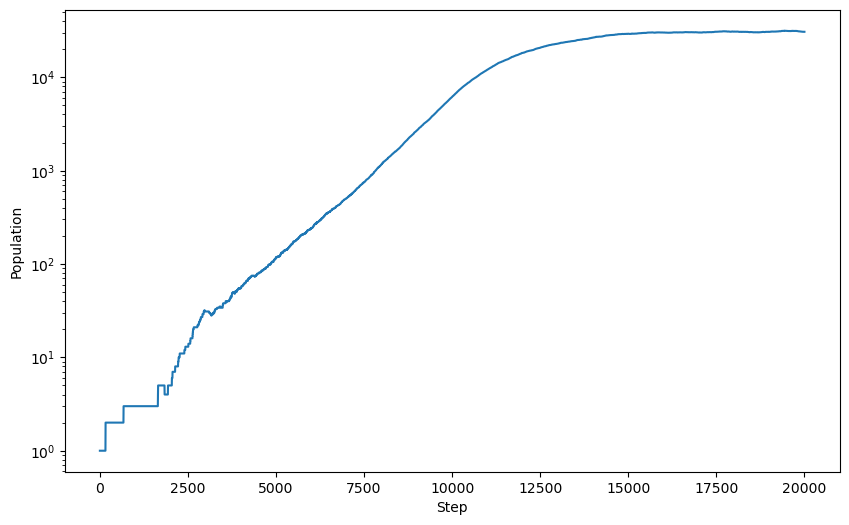

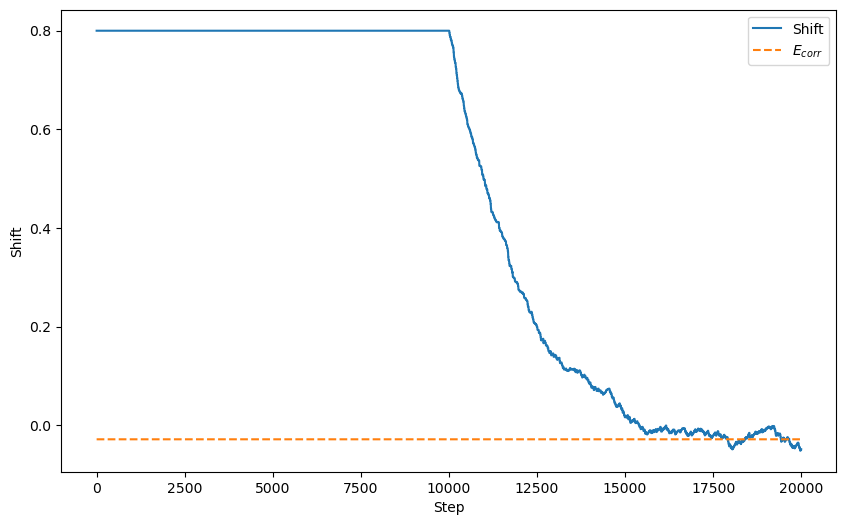

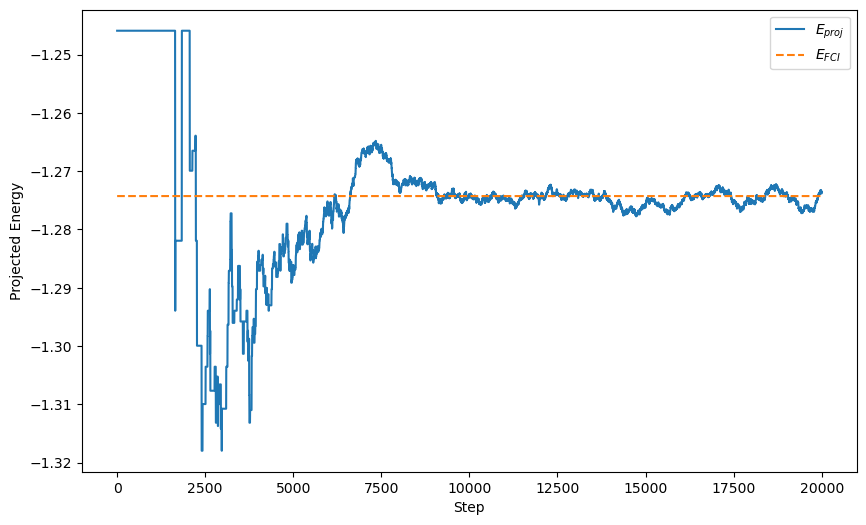

In [119]:
from pyscf import gto

# H3+分子の定義
mol = gto.M(
    atom = "H 0 0 0; H 1 0 0; H 0.5 0.866 0",
    basis = "sto-3g",
    charge = 1,
    spin = 0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.8, n_steps=20000, n_prod=10000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ (STO-3G)
FCI行列は225x225

--- FCI Matrix ---
(3025, 3025)
[[-7.97932157e+00 -5.40677520e-08 -4.87967570e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.40677520e-08 -7.82972761e+00 -3.67903747e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.87967570e-09 -3.67903747e-03 -5.76454482e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  6.69435192e-01
   1.14352847e-16 -6.64063859e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.14352847e-16
   6.69435192e-01 -4.22438528e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -6.64063859e-17
  -4.22438528e-17  9.35981283e-01]]
--- K Matrix ---
[[ 3.55271368e-15 -5.40677520e-08 -4.87967570e-09 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.40677520e-08  1.49593951e-01 -3.67903747e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.87967570e-09 -3.67903747e-03  2.21477674e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]


  2%|█▍                                                                                          | 324/20000 [00:00<00:06, 3233.06it/s]

Step 0: Walkers=1, Shift=0.70000, E_proj=-7.979322
  1 walkers on 0th determinant


  6%|█████▉                                                                                     | 1293/20000 [00:00<00:06, 2880.62it/s]

Step 1000: Walkers=6, Shift=0.70000, E_proj=-7.986267
  5 walkers on 0th determinant
  -1 walkers on 2511th determinant


 10%|█████████▌                                                                                 | 2100/20000 [00:00<00:09, 1951.21it/s]

Step 2000: Walkers=14, Shift=0.70000, E_proj=-8.005668
  7 walkers on 0th determinant
  -1 walkers on 100th determinant
  -1 walkers on 2072th determinant
  -2 walkers on 2016th determinant
  -1 walkers on 2025th determinant
  -1 walkers on 1981th determinant
  -1 walkers on 382th determinant


 15%|██████████████                                                                             | 3085/20000 [00:01<00:14, 1130.93it/s]

Step 3000: Walkers=34, Shift=0.70000, E_proj=-7.990086
  18 walkers on 0th determinant
  -1 walkers on 65th determinant
  1 walkers on 56th determinant
  -1 walkers on 1232th determinant
  1 walkers on 2520th determinant
  -1 walkers on 100th determinant
  1 walkers on 1213th determinant
  -1 walkers on 1982th determinant
  -1 walkers on 1990th determinant
  -3 walkers on 2016th determinant
  -2 walkers on 2025th determinant
  -1 walkers on 1981th determinant
  -1 walkers on 303th determinant
  -1 walkers on 1018th determinant


 20%|██████████████████▊                                                                         | 4081/20000 [00:03<00:24, 658.33it/s]

Step 4000: Walkers=65, Shift=0.70000, E_proj=-7.989441
  38 walkers on 0th determinant
  -1 walkers on 565th determinant
  -1 walkers on 551th determinant
  1 walkers on 1176th determinant
  1 walkers on 586th determinant
  -1 walkers on 870th determinant
  1 walkers on 56th determinant
  -1 walkers on 36th determinant
  1 walkers on 66th determinant
  1 walkers on 351th determinant
  -1 walkers on 2476th determinant
  1 walkers on 1213th determinant
  -1 walkers on 595th determinant
  -2 walkers on 1990th determinant
  1 walkers on 882th determinant
  2 walkers on 1980th determinant
  -1 walkers on 2511th determinant
  -1 walkers on 560th determinant
  -2 walkers on 2016th determinant
  -1 walkers on 835th determinant
  -3 walkers on 2025th determinant
  -1 walkers on 1981th determinant
  1 walkers on 168th determinant


 25%|███████████████████████▎                                                                    | 5062/20000 [00:04<00:27, 539.50it/s]

Step 5000: Walkers=130, Shift=0.70000, E_proj=-8.002925
  70 walkers on 0th determinant
  -1 walkers on 1th determinant
  -1 walkers on 551th determinant
  -1 walkers on 1176th determinant
  1 walkers on 550th determinant
  -1 walkers on 870th determinant
  -1 walkers on 56th determinant
  -1 walkers on 840th determinant
  1 walkers on 1543th determinant
  1 walkers on 101th determinant
  -1 walkers on 36th determinant
  -7 walkers on 2520th determinant
  -1 walkers on 2347th determinant
  -1 walkers on 186th determinant
  1 walkers on 351th determinant
  -1 walkers on 825th determinant
  -4 walkers on 91th determinant
  -1 walkers on 871th determinant
  1 walkers on 359th determinant
  -2 walkers on 2476th determinant
  1 walkers on 1569th determinant
  -1 walkers on 2485th determinant
  -2 walkers on 1990th determinant
  3 walkers on 1980th determinant
  1 walkers on 1546th determinant
  -2 walkers on 560th determinant
  -9 walkers on 2016th determinant
  -1 walkers on 193th determin

 30%|███████████████████████████▊                                                                | 6052/20000 [00:06<00:33, 421.43it/s]

Step 6000: Walkers=273, Shift=0.70000, E_proj=-8.003929
  142 walkers on 0th determinant
  -1 walkers on 17th determinant
  -2 walkers on 565th determinant
  -1 walkers on 1158th determinant
  -2 walkers on 1th determinant
  -1 walkers on 551th determinant
  -4 walkers on 65th determinant
  1 walkers on 126th determinant
  -1 walkers on 1176th determinant
  1 walkers on 550th determinant
  -2 walkers on 586th determinant
  -1 walkers on 870th determinant
  -1 walkers on 56th determinant
  -3 walkers on 1232th determinant
  -1 walkers on 2585th determinant
  -1 walkers on 70th determinant
  1 walkers on 20th determinant
  -20 walkers on 2520th determinant
  -1 walkers on 186th determinant
  2 walkers on 351th determinant
  -1 walkers on 1613th determinant
  1 walkers on 935th determinant
  -1 walkers on 825th determinant
  -7 walkers on 91th determinant
  -2 walkers on 45th determinant
  -2 walkers on 100th determinant
  -3 walkers on 2476th determinant
  1 walkers on 595th determinant


 35%|████████████████████████████████▎                                                           | 7037/20000 [00:09<00:45, 285.22it/s]

Step 7000: Walkers=547, Shift=0.70000, E_proj=-7.997182
  287 walkers on 0th determinant
  1 walkers on 561th determinant
  -1 walkers on 565th determinant
  -3 walkers on 1158th determinant
  -4 walkers on 1th determinant
  1 walkers on 25th determinant
  -5 walkers on 551th determinant
  -2 walkers on 2475th determinant
  -1 walkers on 1100th determinant
  -10 walkers on 65th determinant
  1 walkers on 125th determinant
  1 walkers on 391th determinant
  -1 walkers on 1176th determinant
  -1 walkers on 895th determinant
  2 walkers on 550th determinant
  -1 walkers on 1925th determinant
  3 walkers on 1161th determinant
  -4 walkers on 586th determinant
  -3 walkers on 56th determinant
  -1 walkers on 2585th determinant
  -1 walkers on 37th determinant
  1 walkers on 1995th determinant
  -2 walkers on 70th determinant
  -2 walkers on 1543th determinant
  1 walkers on 2050th determinant
  -1 walkers on 20th determinant
  -2 walkers on 566th determinant
  1 walkers on 1623th determinan

 40%|████████████████████████████████████▋                                                       | 7987/20000 [00:12<00:45, 266.85it/s]

Step 8000: Walkers=1105, Shift=0.70000, E_proj=-8.011014
  532 walkers on 0th determinant
  1 walkers on 561th determinant
  2 walkers on 1231th determinant
  -4 walkers on 1158th determinant
  -4 walkers on 1th determinant
  1 walkers on 413th determinant
  1 walkers on 1996th determinant
  -18 walkers on 551th determinant
  -7 walkers on 2475th determinant
  -20 walkers on 65th determinant
  -1 walkers on 242th determinant
  1 walkers on 125th determinant
  1 walkers on 2521th determinant
  -1 walkers on 120th determinant
  -1 walkers on 2th determinant
  -8 walkers on 1176th determinant
  14 walkers on 550th determinant
  -1 walkers on 1925th determinant
  10 walkers on 1161th determinant
  1 walkers on 121th determinant
  -14 walkers on 586th determinant
  -6 walkers on 870th determinant
  -8 walkers on 56th determinant
  -1 walkers on 916th determinant
  1 walkers on 2541th determinant
  2 walkers on 1217th determinant
  2 walkers on 840th determinant
  -2 walkers on 896th determi

Step 9000: Walkers=1877, Shift=0.37839, E_proj=-7.998022
  945 walkers on 0th determinant
  -1 walkers on 1599th determinant
  1 walkers on 1231th determinant
  -3 walkers on 565th determinant
  -4 walkers on 1158th determinant
  -2 walkers on 1th determinant
  1 walkers on 1996th determinant
  -1 walkers on 71th determinant
  -3 walkers on 25th determinant
  -35 walkers on 551th determinant
  -17 walkers on 2475th determinant
  -1 walkers on 1100th determinant
  1 walkers on 41th determinant
  -27 walkers on 65th determinant
  -1 walkers on 2045th determinant
  3 walkers on 1705th determinant
  1 walkers on 391th determinant
  1 walkers on 126th determinant
  -7 walkers on 1176th determinant
  19 walkers on 550th determinant
  1 walkers on 1162th determinant
  14 walkers on 1161th determinant
  -24 walkers on 586th determinant
  -9 walkers on 870th determinant
  -14 walkers on 56th determinant
  -3 walkers on 1232th determinant
  1 walkers on 187th determinant
  -1 walkers on 37th det

 45%|█████████████████████████████████████████▌                                                  | 9023/20000 [00:17<01:27, 124.94it/s]

  -1 walkers on 2866th determinant
  -1 walkers on 1150th determinant
  1 walkers on 2510th determinant
  -1 walkers on 1436th determinant
  -1 walkers on 1694th determinant
  -1 walkers on 1720th determinant
  -1 walkers on 1821th determinant
  2 walkers on 721th determinant
  1 walkers on 743th determinant
  -1 walkers on 1491th determinant
  -1 walkers on 319th determinant
  1 walkers on 1437th determinant
  1 walkers on 1451th determinant
  1 walkers on 348th determinant
  1 walkers on 1433th determinant
  -1 walkers on 1173th determinant
  2 walkers on 1111th determinant
  1 walkers on 1390th determinant
  -1 walkers on 199th determinant
  -1 walkers on 1094th determinant
  1 walkers on 1918th determinant
  1 walkers on 767th determinant
  -1 walkers on 1422th determinant


 50%|█████████████████████████████████████████████▉                                              | 9985/20000 [00:22<00:59, 169.03it/s]

Step 10000: Walkers=2425, Shift=-0.02355, E_proj=-8.002065
  1171 walkers on 0th determinant
  1 walkers on 561th determinant
  1 walkers on 1231th determinant
  -10 walkers on 565th determinant
  -4 walkers on 1158th determinant
  12 walkers on 1th determinant
  2 walkers on 413th determinant
  1 walkers on 2477th determinant
  2 walkers on 1996th determinant
  1 walkers on 25th determinant
  -27 walkers on 551th determinant
  -14 walkers on 2475th determinant
  -1 walkers on 41th determinant
  -28 walkers on 65th determinant
  -1 walkers on 2045th determinant
  1 walkers on 126th determinant
  2 walkers on 2521th determinant
  -1 walkers on 352th determinant
  1 walkers on 120th determinant
  -17 walkers on 1176th determinant
  1 walkers on 895th determinant
  23 walkers on 550th determinant
  -1 walkers on 1162th determinant
  1 walkers on 38th determinant
  7 walkers on 1161th determinant
  1 walkers on 121th determinant
  -30 walkers on 586th determinant
  -9 walkers on 870th dete

 50%|██████████████████████████████████████████████                                              | 10003/20000 [00:22<01:40, 99.26it/s]

  1 walkers on 721th determinant
  1 walkers on 768th determinant
  -1 walkers on 698th determinant
  1 walkers on 1513th determinant
  1 walkers on 2692th determinant
  -1 walkers on 1066th determinant
  -1 walkers on 798th determinant
  1 walkers on 183th determinant
  -1 walkers on 559th determinant
  1 walkers on 349th determinant
  -1 walkers on 1154th determinant
  1 walkers on 1775th determinant
  1 walkers on 1683th determinant
  -1 walkers on 1643th determinant
  -1 walkers on 1874th determinant
  -1 walkers on 977th determinant
  -1 walkers on 309th determinant
  -1 walkers on 767th determinant
  1 walkers on 1792th determinant
  1 walkers on 1050th determinant


 55%|██████████████████████████████████████████████████                                         | 11000/20000 [00:28<00:48, 186.71it/s]

Step 11000: Walkers=2270, Shift=0.07407, E_proj=-7.993051
  1215 walkers on 0th determinant
  1 walkers on 561th determinant
  1 walkers on 1238th determinant
  1 walkers on 1231th determinant
  -1 walkers on 17th determinant
  -7 walkers on 565th determinant
  -5 walkers on 1158th determinant
  24 walkers on 1th determinant
  1 walkers on 1996th determinant
  -4 walkers on 42th determinant
  2 walkers on 71th determinant
  -2 walkers on 25th determinant
  -25 walkers on 551th determinant
  -14 walkers on 2475th determinant
  1 walkers on 41th determinant
  -17 walkers on 65th determinant
  2 walkers on 126th determinant
  1 walkers on 352th determinant
  1 walkers on 120th determinant
  -18 walkers on 1176th determinant
  24 walkers on 550th determinant
  -4 walkers on 1162th determinant
  6 walkers on 1161th determinant
  1 walkers on 121th determinant
  -27 walkers on 586th determinant
  -6 walkers on 870th determinant
  -30 walkers on 56th determinant
  -1 walkers on 2541th determi

 60%|██████████████████████████████████████████████████████▌                                    | 11989/20000 [00:33<00:44, 181.90it/s]

Step 12000: Walkers=2572, Shift=0.07851, E_proj=-7.995071
  1344 walkers on 0th determinant
  9 walkers on 1231th determinant
  -1 walkers on 17th determinant
  -5 walkers on 565th determinant
  -2 walkers on 1158th determinant
  30 walkers on 1th determinant
  2 walkers on 413th determinant
  1 walkers on 1996th determinant
  -37 walkers on 551th determinant
  3 walkers on 615th determinant
  -11 walkers on 2475th determinant
  -1 walkers on 41th determinant
  -30 walkers on 65th determinant
  1 walkers on 1705th determinant
  2 walkers on 391th determinant
  1 walkers on 126th determinant
  2 walkers on 2521th determinant
  -3 walkers on 352th determinant
  -2 walkers on 47th determinant
  1 walkers on 120th determinant
  1 walkers on 1616th determinant
  -37 walkers on 1176th determinant
  26 walkers on 550th determinant
  21 walkers on 1161th determinant
  -1 walkers on 121th determinant
  1 walkers on 651th determinant
  -29 walkers on 586th determinant
  -8 walkers on 870th deter

 65%|███████████████████████████████████████████████████████████                                | 12981/20000 [00:38<00:35, 196.62it/s]

Step 13000: Walkers=3019, Shift=0.15985, E_proj=-7.996206
  1545 walkers on 0th determinant
  -1 walkers on 1599th determinant
  -1 walkers on 561th determinant
  5 walkers on 1231th determinant
  -7 walkers on 565th determinant
  -8 walkers on 1158th determinant
  37 walkers on 1th determinant
  1 walkers on 2477th determinant
  3 walkers on 42th determinant
  -1 walkers on 71th determinant
  -34 walkers on 551th determinant
  2 walkers on 615th determinant
  -12 walkers on 2475th determinant
  -1 walkers on 1100th determinant
  -1 walkers on 41th determinant
  -45 walkers on 65th determinant
  5 walkers on 1705th determinant
  2 walkers on 391th determinant
  1 walkers on 126th determinant
  1 walkers on 2521th determinant
  2 walkers on 120th determinant
  -24 walkers on 1176th determinant
  1 walkers on 895th determinant
  -1 walkers on 50th determinant
  30 walkers on 550th determinant
  -2 walkers on 1162th determinant
  -2 walkers on 38th determinant
  15 walkers on 1161th deter

 65%|███████████████████████████████████████████████████████████▏                               | 13017/20000 [00:39<01:03, 109.24it/s]

  -1 walkers on 743th determinant
  1 walkers on 856th determinant
  1 walkers on 2882th determinant
  -1 walkers on 1843th determinant
  -1 walkers on 1600th determinant
  1 walkers on 1873th determinant
  -1 walkers on 1329th determinant
  2 walkers on 776th determinant
  1 walkers on 2627th determinant
  1 walkers on 483th determinant
  -1 walkers on 1452th determinant
  -1 walkers on 225th determinant
  -1 walkers on 1657th determinant
  1 walkers on 1742th determinant
  1 walkers on 1174th determinant
  -1 walkers on 1643th determinant
  1 walkers on 2172th determinant
  -1 walkers on 1479th determinant


Step 14000: Walkers=3257, Shift=0.02706, E_proj=-7.998848
  1669 walkers on 0th determinant
  -2 walkers on 1599th determinant
  1 walkers on 561th determinant
  3 walkers on 1231th determinant
  -1 walkers on 17th determinant
  -4 walkers on 565th determinant
  32 walkers on 1th determinant
  3 walkers on 1996th determinant
  -2 walkers on 42th determinant
  1 walkers on 71th determinant
  -3 walkers on 25th determinant
  -28 walkers on 551th determinant
  2 walkers on 615th determinant
  -16 walkers on 2475th determinant
  -1 walkers on 41th determinant
  2 walkers on 407th determinant
  -40 walkers on 65th determinant
  -4 walkers on 2045th determinant
  3 walkers on 1705th determinant
  2 walkers on 391th determinant
  -1 walkers on 47th determinant
  1 walkers on 120th determinant
  -19 walkers on 1176th determinant
  -1 walkers on 50th determinant
  34 walkers on 550th determinant
  -1 walkers on 38th determinant
  40 walkers on 1161th determinant
  -1 walkers on 651th determinan

 70%|████████████████████████████████████████████████████████████████▍                           | 14013/20000 [00:44<01:03, 94.08it/s]

  1 walkers on 672th determinant
  -1 walkers on 2297th determinant
  -1 walkers on 1436th determinant
  1 walkers on 454th determinant
  -1 walkers on 2761th determinant
  -1 walkers on 792th determinant
  1 walkers on 1960th determinant
  1 walkers on 570th determinant
  -1 walkers on 1317th determinant
  1 walkers on 127th determinant
  1 walkers on 1218th determinant
  1 walkers on 1229th determinant
  -1 walkers on 353th determinant
  -1 walkers on 698th determinant
  -1 walkers on 1600th determinant
  1 walkers on 2873th determinant
  -1 walkers on 2627th determinant
  -1 walkers on 1433th determinant
  -1 walkers on 2817th determinant
  -1 walkers on 1625th determinant
  1 walkers on 1112th determinant
  -1 walkers on 2506th determinant
  -1 walkers on 636th determinant
  -1 walkers on 1469th determinant
  -1 walkers on 676th determinant
  -1 walkers on 2900th determinant


Step 15000: Walkers=3265, Shift=0.06980, E_proj=-7.994113
  1770 walkers on 0th determinant
  2 walkers on 561th determinant
  8 walkers on 1231th determinant
  -2 walkers on 565th determinant
  -5 walkers on 1158th determinant
  38 walkers on 1th determinant
  -2 walkers on 42th determinant
  -1 walkers on 71th determinant
  -1 walkers on 25th determinant
  -47 walkers on 551th determinant
  3 walkers on 615th determinant
  -29 walkers on 2475th determinant
  -2 walkers on 1100th determinant
  -1 walkers on 389th determinant
  -1 walkers on 41th determinant
  -40 walkers on 65th determinant
  -2 walkers on 242th determinant
  -1 walkers on 125th determinant
  3 walkers on 391th determinant
  3 walkers on 126th determinant
  -4 walkers on 352th determinant
  -1 walkers on 47th determinant
  -26 walkers on 1176th determinant
  -1 walkers on 50th determinant
  36 walkers on 550th determinant
  -1 walkers on 1925th determinant
  -1 walkers on 38th determinant
  29 walkers on 1161th determ

 75%|████████████████████████████████████████████████████████████████████▎                      | 15010/20000 [00:50<00:46, 107.75it/s]

  1 walkers on 2228th determinant
  2 walkers on 1678th determinant
  -1 walkers on 1101th determinant
  2 walkers on 2943th determinant
  -1 walkers on 2765th determinant
  -1 walkers on 670th determinant
  -1 walkers on 198th determinant
  -1 walkers on 2701th determinant
  1 walkers on 2325th determinant
  1 walkers on 2306th determinant
  -2 walkers on 1573th determinant
  -1 walkers on 1770th determinant
  -1 walkers on 2388th determinant
  -1 walkers on 672th determinant
  1 walkers on 2762th determinant
  -1 walkers on 617th determinant
  1 walkers on 1436th determinant
  1 walkers on 2330th determinant
  -1 walkers on 2587th determinant
  1 walkers on 749th determinant
  1 walkers on 319th determinant
  -1 walkers on 1451th determinant
  -1 walkers on 581th determinant
  -1 walkers on 1433th determinant
  1 walkers on 1567th determinant
  -1 walkers on 1111th determinant
  -1 walkers on 2645th determinant
  -1 walkers on 850th determinant
  1 walkers on 2791th determinant
  -1 

Step 16000: Walkers=3638, Shift=0.05536, E_proj=-7.999830
  1886 walkers on 0th determinant
  1 walkers on 561th determinant
  1 walkers on 1231th determinant
  -2 walkers on 17th determinant
  -6 walkers on 565th determinant
  -6 walkers on 1158th determinant
  58 walkers on 1th determinant
  7 walkers on 1996th determinant
  -5 walkers on 42th determinant
  -3 walkers on 71th determinant
  -52 walkers on 551th determinant
  1 walkers on 615th determinant
  -21 walkers on 2475th determinant
  -1 walkers on 1100th determinant
  -1 walkers on 41th determinant
  -36 walkers on 65th determinant
  1 walkers on 2045th determinant
  -2 walkers on 125th determinant
  1 walkers on 391th determinant
  -2 walkers on 352th determinant
  1 walkers on 47th determinant
  2 walkers on 120th determinant
  -1 walkers on 2th determinant
  -19 walkers on 1176th determinant
  2 walkers on 50th determinant
  46 walkers on 550th determinant
  -1 walkers on 1925th determinant
  21 walkers on 1161th determina

 80%|████████████████████████████████████████████████████████████████████████▊                  | 16010/20000 [00:56<00:39, 101.26it/s]

  -2 walkers on 791th determinant
  1 walkers on 1271th determinant
  1 walkers on 588th determinant
  -2 walkers on 2357th determinant
  1 walkers on 2423th determinant
  1 walkers on 278th determinant
  -1 walkers on 79th determinant
  -1 walkers on 333th determinant
  1 walkers on 356th determinant
  1 walkers on 936th determinant
  1 walkers on 188th determinant
  -1 walkers on 2076th determinant
  -1 walkers on 1178th determinant
  1 walkers on 195th determinant
  -1 walkers on 2110th determinant
  -1 walkers on 1101th determinant
  1 walkers on 2943th determinant
  -1 walkers on 198th determinant
  -1 walkers on 323th determinant
  -1 walkers on 2801th determinant
  1 walkers on 1573th determinant
  -1 walkers on 947th determinant
  1 walkers on 253th determinant
  -1 walkers on 2175th determinant
  1 walkers on 643th determinant
  1 walkers on 617th determinant
  -2 walkers on 233th determinant
  -1 walkers on 1818th determinant
  -1 walkers on 1506th determinant
  1 walkers on 

Step 17000: Walkers=4257, Shift=0.13640, E_proj=-8.003357
  2105 walkers on 0th determinant
  -4 walkers on 1599th determinant
  1 walkers on 561th determinant
  9 walkers on 1231th determinant
  -18 walkers on 565th determinant
  -5 walkers on 1158th determinant
  68 walkers on 1th determinant
  1 walkers on 413th determinant
  1 walkers on 1996th determinant
  -1 walkers on 25th determinant
  -67 walkers on 551th determinant
  1 walkers on 615th determinant
  -17 walkers on 2475th determinant
  -7 walkers on 1100th determinant
  -3 walkers on 41th determinant
  -45 walkers on 65th determinant
  1 walkers on 1705th determinant
  1 walkers on 126th determinant
  -2 walkers on 47th determinant
  -1 walkers on 120th determinant
  1 walkers on 1184th determinant
  -9 walkers on 1176th determinant
  2 walkers on 2530th determinant
  -2 walkers on 50th determinant
  43 walkers on 550th determinant
  16 walkers on 1161th determinant
  1 walkers on 121th determinant
  -1 walkers on 651th dete

 85%|█████████████████████████████████████████████████████████████████████████████▎             | 16999/20000 [01:03<00:19, 151.35it/s]

  2 walkers on 570th determinant
  -1 walkers on 2605th determinant
  -1 walkers on 2887th determinant
  1 walkers on 1680th determinant
  1 walkers on 1288th determinant
  -1 walkers on 743th determinant
  -1 walkers on 1843th determinant
  -1 walkers on 1488th determinant
  1 walkers on 736th determinant
  1 walkers on 272th determinant
  -1 walkers on 1899th determinant
  -1 walkers on 1066th determinant
  -1 walkers on 798th determinant
  1 walkers on 141th determinant
  1 walkers on 1051th determinant
  -1 walkers on 1891th determinant
  -1 walkers on 1451th determinant
  2 walkers on 993th determinant
  -1 walkers on 1233th determinant
  -1 walkers on 625th determinant
  1 walkers on 2663th determinant
  -1 walkers on 2648th determinant
  -1 walkers on 581th determinant
  3 walkers on 646th determinant
  -1 walkers on 1438th determinant
  1 walkers on 183th determinant
  1 walkers on 2945th determinant
  -1 walkers on 2506th determinant
  1 walkers on 834th determinant
  -1 walke

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 17996/20000 [01:10<00:13, 153.12it/s]

Step 18000: Walkers=4658, Shift=0.04817, E_proj=-8.000511
  2290 walkers on 0th determinant
  4 walkers on 561th determinant
  10 walkers on 1231th determinant
  -3 walkers on 17th determinant
  -22 walkers on 565th determinant
  -18 walkers on 1158th determinant
  73 walkers on 1th determinant
  1 walkers on 413th determinant
  1 walkers on 2477th determinant
  1 walkers on 1996th determinant
  -1 walkers on 42th determinant
  -1 walkers on 71th determinant
  -1 walkers on 25th determinant
  -38 walkers on 551th determinant
  -22 walkers on 2475th determinant
  -1 walkers on 1100th determinant
  -2 walkers on 41th determinant
  -65 walkers on 65th determinant
  -1 walkers on 242th determinant
  1 walkers on 2045th determinant
  1 walkers on 125th determinant
  -1 walkers on 391th determinant
  3 walkers on 126th determinant
  2 walkers on 2521th determinant
  -2 walkers on 352th determinant
  -1 walkers on 47th determinant
  2 walkers on 120th determinant
  -8 walkers on 1176th determ

 90%|█████████████████████████████████████████████████████████████████████████████████▉         | 17996/20000 [01:10<00:13, 153.12it/s]

  2 walkers on 2311th determinant
  1 walkers on 1145th determinant
  1 walkers on 2473th determinant
  -24 walkers on 168th determinant
  1 walkers on 2166th determinant
  -1 walkers on 2144th determinant
  1 walkers on 2386th determinant
  1 walkers on 2027th determinant
  2 walkers on 2265th determinant
  -1 walkers on 950th determinant
  1 walkers on 1580th determinant
  2 walkers on 1547th determinant
  1 walkers on 567th determinant
  2 walkers on 2595th determinant
  1 walkers on 2011th determinant
  1 walkers on 2173th determinant
  -2 walkers on 2300th determinant
  1 walkers on 604th determinant
  1 walkers on 1207th determinant
  -1 walkers on 2372th determinant
  1 walkers on 849th determinant
  -2 walkers on 2346th determinant
  1 walkers on 357th determinant
  1 walkers on 3016th determinant
  1 walkers on 2448th determinant
  1 walkers on 2469th determinant
  -1 walkers on 575th determinant
  1 walkers on 2244th determinant
  -1 walkers on 496th determinant
  1 walkers o

 95%|██████████████████████████████████████████████████████████████████████████████████████▍    | 18995/20000 [01:17<00:06, 149.48it/s]

Step 19000: Walkers=4549, Shift=-0.04431, E_proj=-7.995103
  2365 walkers on 0th determinant
  5 walkers on 1231th determinant
  -33 walkers on 565th determinant
  -12 walkers on 1158th determinant
  58 walkers on 1th determinant
  1 walkers on 2477th determinant
  -3 walkers on 1996th determinant
  -5 walkers on 25th determinant
  -54 walkers on 551th determinant
  6 walkers on 615th determinant
  -25 walkers on 2475th determinant
  1 walkers on 1100th determinant
  1 walkers on 389th determinant
  -2 walkers on 41th determinant
  1 walkers on 407th determinant
  -70 walkers on 65th determinant
  -2 walkers on 242th determinant
  -9 walkers on 2045th determinant
  3 walkers on 125th determinant
  1 walkers on 1705th determinant
  7 walkers on 391th determinant
  3 walkers on 2521th determinant
  -4 walkers on 352th determinant
  -4 walkers on 2th determinant
  -11 walkers on 1176th determinant
  27 walkers on 550th determinant
  -1 walkers on 1162th determinant
  22 walkers on 1161th 

 95%|███████████████████████████████████████████████████████████████████████████████████████▍    | 19010/20000 [01:17<00:12, 76.23it/s]

  1 walkers on 2228th determinant
  -1 walkers on 1678th determinant
  1 walkers on 2517th determinant
  2 walkers on 1110th determinant
  1 walkers on 2943th determinant
  1 walkers on 2765th determinant
  -1 walkers on 1365th determinant
  1 walkers on 1554th determinant
  1 walkers on 2325th determinant
  -1 walkers on 2577th determinant
  -1 walkers on 1573th determinant
  1 walkers on 1761th determinant
  -1 walkers on 2866th determinant
  1 walkers on 2693th determinant
  1 walkers on 1553th determinant
  -1 walkers on 2761th determinant
  1 walkers on 845th determinant
  -1 walkers on 2424th determinant
  -1 walkers on 570th determinant
  1 walkers on 759th determinant
  1 walkers on 1458th determinant
  -1 walkers on 2882th determinant
  1 walkers on 1899th determinant
  -1 walkers on 1600th determinant
  2 walkers on 1051th determinant
  -1 walkers on 1329th determinant
  -1 walkers on 2752th determinant
  -1 walkers on 1940th determinant
  1 walkers on 1111th determinant
  1 

100%|███████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:24<00:00, 236.27it/s]



---- Walkers (result) ----
2326 walkers on 0th determinant
-1 walkers on 1599th determinant
-1 walkers on 561th determinant
8 walkers on 1231th determinant
-11 walkers on 565th determinant
-8 walkers on 1158th determinant
64 walkers on 1th determinant
1 walkers on 2477th determinant
-4 walkers on 42th determinant
-3 walkers on 71th determinant
-57 walkers on 551th determinant
4 walkers on 615th determinant
-40 walkers on 2475th determinant
-79 walkers on 65th determinant
-7 walkers on 2045th determinant
-1 walkers on 1705th determinant
1 walkers on 391th determinant
-1 walkers on 352th determinant
2 walkers on 120th determinant
-2 walkers on 1616th determinant
-12 walkers on 1176th determinant
-1 walkers on 895th determinant
34 walkers on 550th determinant
-1 walkers on 1162th determinant
22 walkers on 1161th determinant
-1 walkers on 121th determinant
-63 walkers on 586th determinant
-29 walkers on 870th determinant
-27 walkers on 56th determinant
1 walkers on 2071th determinant
1 wa

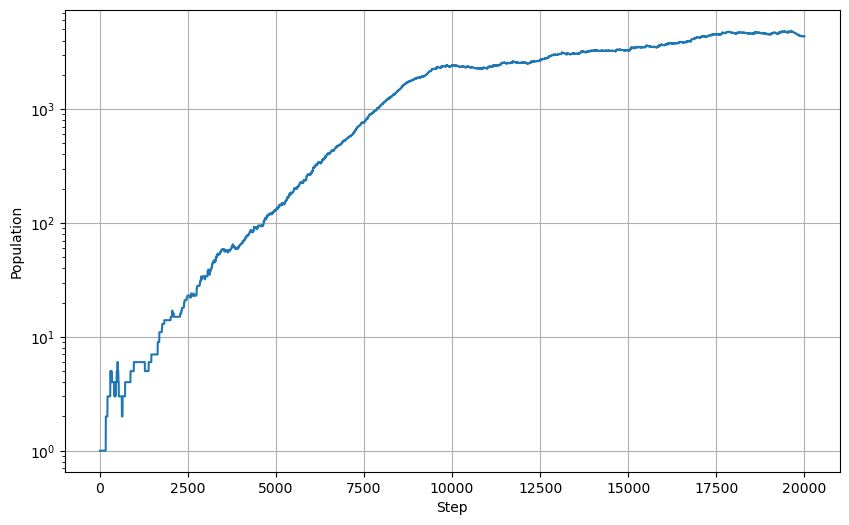

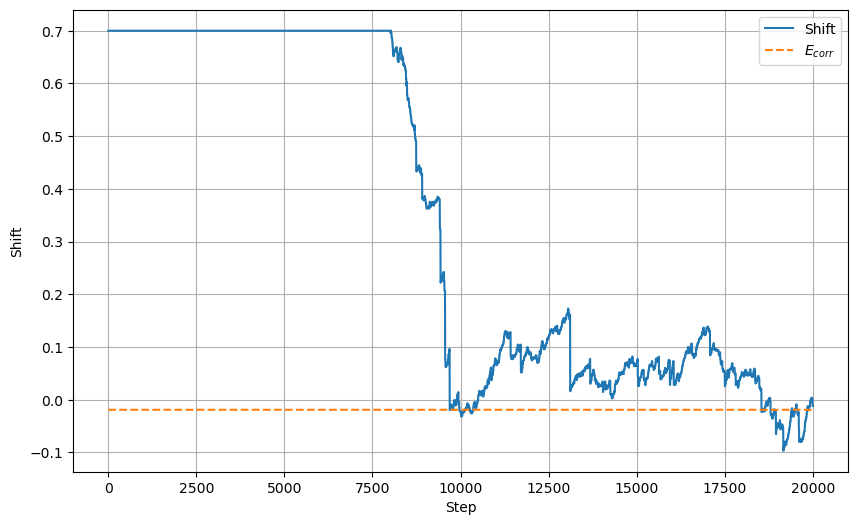

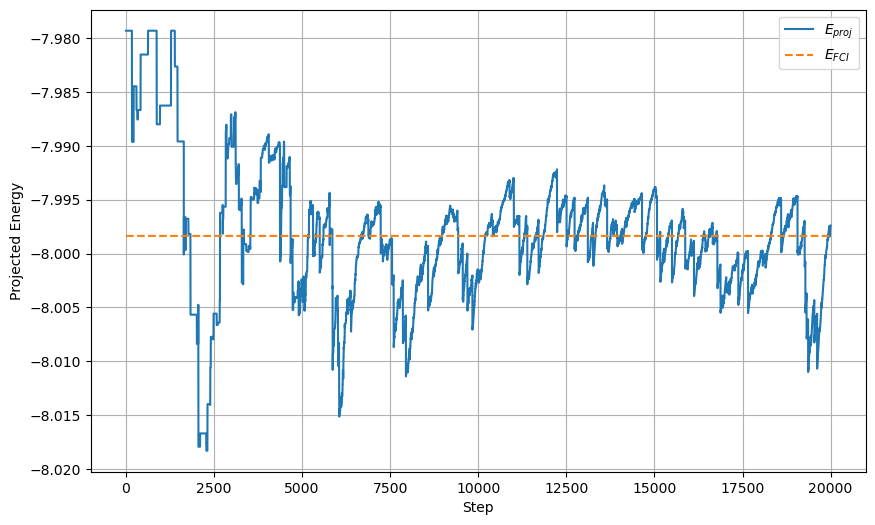

In [25]:
from pyscf import gto

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    # basis="6-31g"
    g",
    spin=0,      # singlet
    verbose=0
)
E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, shift=0.7, n_steps=20000, n_prod=10000, step_starting_shift_upd=8000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} ± {E_sd: .6f} Ha")
print(f"Average shift: {avg_shift:.6f} Ha => Energy: {avg_shift + E_HF}")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${LiH}$ 分子 STO-3G, ステップ数ごとの標準偏差の確認
ステップ数を増やすと非常に実行に時間がかかる。

--- FCI Matrix ---
(225, 225)
[[-7.86186477e+00  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08 -7.70892352e+00 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02 -5.80885774e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.46233425e+00
   1.50382491e-17  8.78436185e-18]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  1.50382491e-17
  -1.41526201e+00 -3.47698264e-17]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  8.78436185e-18
  -3.47698264e-17 -1.38152373e+00]]
--- K Matrix ---
[[-1.77635684e-15  1.27143444e-08 -1.26871539e-10 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.27143444e-08  1.52941253e-01 -1.12113377e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-1.26871539e-10 -1.12113377e-02  2.05300703e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 .

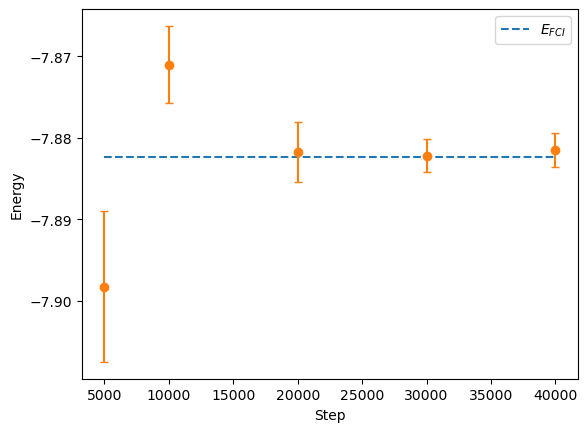

In [13]:
from pyscf import gto

n_steps_arr = [5000, 10000, 20000, 30000, 40000]

# LiH分子の定義
mol = gto.M(
    atom=f"Li 0 0 0; H 0 0 1.6",
    basis="sto-3g",
    spin=0,      # singlet
    verbose=0
)

E = []
sd = []

for n_steps in n_steps_arr:
    E_est, E_sd, E_fci, E_HF, avg_shift, hist_population, hist_shift, hist_energy = \
        FCIQMC(mol, shift=0.7, init_n_walker=1, n_steps=n_steps, n_prod=n_steps//4, step_starting_shift_upd=n_steps//4, debug=False)
    E.append(E_est)
    sd.append(E_sd)

E_fci_arr = np.full_like(n_steps_arr, E_fci, dtype=float)
plt.plot(n_steps_arr, E_fci_arr, linestyle="--", label=r"${E_{FCI}}$")
plt.errorbar(n_steps_arr, E, yerr=sd, fmt='o', capsize=3)
plt.xlabel('Step')
plt.ylabel('Energy')
plt.legend()
plt.show()

In [ ]:
from pyscf import gto

R_ang = 1.242  # C2 の平衡結合長（Å）

mol = gto.M(
    atom=f"C 0 0 0; C 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    charge=0,
    spin=0,      # singlet (Nα - Nβ = 0)
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=10000, n_prod=5000, step_starting_shift_upd=10000)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)


## ${N_2}$ at equilibrium
FCI行列が巨大過ぎて生成出来ない。必要な成分のみ取ってくる実装（on the fly?）に変える必要がありそう

In [ ]:
from pyscf import gto

# N2 at equilibriumの定義
R_bohr = 2.068     # a0
R_ang = R_bohr * 0.529177

mol = gto.M(
    atom=f"N 0 0 0; N 0 0 {R_ang}",
    basis="cc-pVDZ",
    unit="Angstrom",
    spin=0,      # singlet
    verbose=0
)
E_est, E_fci, E_HF, hist_population, hist_shift, hist_energy = \
    FCIQMC(mol, n_steps=1000, n_prod=500, step_starting_shift_upd=100)

# 結果を出力
print("-" * 30)
print(f"FCI Energy: {E_fci:.6f} Ha")
print(f"Final FCIQMC Energy: {E_est:.6f} Ha")
plot_result(E_fci, E_HF, hist_population, hist_shift, hist_energy)
